<a href="https://colab.research.google.com/github/andjelkovicmirjana/ORI---Projekat/blob/main/Projekat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. UČITAVANJE I RASPAKIVANJE DATASETA
Ovaj korak učitava TrashNet dataset koji je preuzet na lokalni računar u Google Colab okruženje zatim ga raspakuje u odgovarajuću folder strukturu za dalju obradu. Dataset sadrži slike otpada organizovane po klasama (cardboard, glass, metal, paper, plastic, trash) koje će se koristiti za treniranje CNN modela.

In [6]:
print("Import TrashNet dataset:")
from google.colab import files
uploaded = files.upload()

!unzip -q *.zip -d /content/
!ls -la /content/dataset-resized/

print("Unpack dataset!")

Import TrashNet dataset:


Saving archive.zip to archive.zip
total 112
drwxr-xr-x 8 root root  4096 Sep 20 05:32 .
drwxr-xr-x 1 root root  4096 Sep 20 05:32 ..
drwxr-xr-x 2 root root 20480 Sep 20 05:32 cardboard
drwxr-xr-x 2 root root 20480 Sep 20 05:32 glass
drwxr-xr-x 2 root root 16384 Sep 20 05:32 metal
drwxr-xr-x 2 root root 20480 Sep 20 05:32 paper
drwxr-xr-x 2 root root 20480 Sep 20 05:32 plastic
drwxr-xr-x 2 root root  4096 Sep 20 05:32 trash
Unpack dataset!


# 2. IMPORTOVANJE POTREBNIH BIBLIOTEKA

Ovaj korak uvozi sve potrebne Python biblioteke za implementaciju CNN modelanza klasifikaciju otpada. Biblioteke su organizovane po kategorijama:
- Computer vision i obrada slika
- Osnovna obrada podataka i matematičke operacije
- Vizualizacija rezultata
- Machine learning evaluacija i metriken
- Web funkcionalnosti
- Deep learning i neuronske mreže

In [7]:
import cv2
from imutils import paths

import numpy as np
import pandas as pd
import itertools
import random, os, glob

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix

import urllib
from urllib.request import urlopen

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

# 3. DEFINISANJE PARAMETARA I UČITAVANJE DATASETA

Ovaj deo koda definiše ključne parametre za preprocessing slika i mapiranje klasa otpada. target_size određuje standardnu veličinu na koju će se sve slike skalirati pre ulaska u CNN model, dok waste_labels mapira nazive klasa otpada na numeričke identifikatore potrebne za treniranje.

In [8]:
target_size = (224, 224)
waste_labels = {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

Funkcija load_datasets čita sve slike iz direktorijuma, skalira ih na standardnu veličinu, izvlači labele iz naziva foldera i vraća preprocessirane podatke spremne za treniranje CNN modela. Koristi se OpenCV za čitanje slika i imutils biblioteka za navigaciju kroz folder strukturu.

In [9]:
def load_datasets(path):
  x = []
  labels = []

  image_paths = sorted(list(paths.list_images(path)))

  for image_path in image_paths:
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    x.append(img)
    label = image_path.split(os.path.sep)[-2]
    labels.append(waste_labels[label])
    x, labels = shuffle(x, labels, random_state = 42)

  print(f"X size: {np.array(x).shape}")
  print(f"Label class number: {len(np.unique(labels))} Number of observations: {len(labels)}")

  return x, labels

Ovaj deo poziva funkciju za učitavanje dataseta i definiše input_shape koji će se koristiti u CNN modelu. Input_shape predstavlja dimenzije tensor-a koji model očekuje na ulazu (visina, širina, broj kanala).

In [10]:
dir_path = '/content/dataset-resized'
x, labels = load_datasets(dir_path)

input_shape = (np.array(x[0]).shape[1],np.array(x[0]).shape[1], 3)
print(input_shape)

X size: (2527, 224, 224, 3)
Label class number: 6 Number of observations: 2527
(224, 224, 3)


Ova funkcija kreira grid od 12 slika iz učitanog dataseta radi vizuelne provere kvaliteta podataka i ispravnosti labela. Prikazuje nasumične slike sa odgovarajućim nazivima klasa otpada, što omogućava brzu validaciju da li je dataset ispravno učitan i labeled.

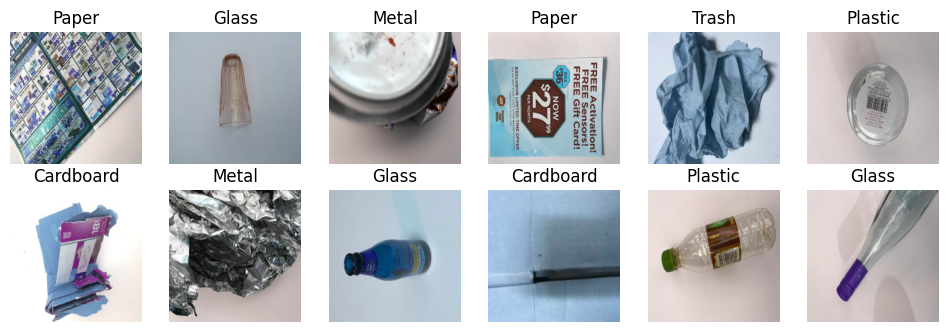

In [11]:
def visualize_img(image_batch, label_batch):
  plt.figure(figsize=(12, 12))
  for n in range(12):
    ax = plt.subplot(6,6,n+1)
    plt.imshow(image_batch[n])
    plt.title(np.array(list(waste_labels.keys()))[to_categorical(labels, num_classes=6)[n]==1][0].title())
    plt.axis('off')

visualize_img(x, labels)

# 4. KREIRANJE DATA GENERATOR-A ZA TRENIRANJE I VALIDACIJU

Ovaj deo kreira ImageDataGenerator objekat koji omogućavaju data augmentation.

In [12]:
train = ImageDataGenerator(horizontal_flip=True,
                           vertical_flip=True,
                           validation_split=0.1,
                           rescale=1./255,
                           shear_range = 0.1,
                           zoom_range = 0.1,
                           width_shift_range= 0.1,
                           height_shift_range = 0.1)

test = ImageDataGenerator(rescale=1/255,
                          validation_split=0.1)

Sledi povezivanje ImageDataGenerator-a sa folder strukturom dataseta.

In [13]:
train_generator=train.flow_from_directory(directory=dir_path,
                                          target_size=(target_size),
                                          class_mode='categorical',
                                          subset='training')

test_generator=test.flow_from_directory(directory=dir_path,
                                        target_size=(target_size),
                                        batch_size=251,
                                        class_mode='categorical',
                                        subset='validation')

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


# 5. KREIRANJE, KOMPAJLIRANJE I TRENIRANJE CNN MODELA

Ovaj deo je zadužen za definisanje sekvencijalnog CNN modela sa konvolucionim slojevima za ekstrakciju osobina i dense slojevima za klasifikaciju u 6 kategorija otpada.

In [14]:
model=Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=(input_shape), activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', input_shape=(input_shape), activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=(input_shape), activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Flatten())

model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(units=32, activation='relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(units=6, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,645,830 (6.28 MB)

 Trainable params: 1,645,830 (6.28 MB)

 Non-trainable params: 0 (0.00 B)

Sledi kompajliranje modela sa optimizerom, loss funkcijom i callback-ovima za praćenje treniranja i automatsko čuvanje najboljeg modela

In [15]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), "acc"])

callbacks = [EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode="min"),

             ModelCheckpoint(filepath='mymodel.keras', monitor='val_loss', mode='min', save_best_only=True, save_weights_only=False, verbose=1)]

Pokretanje procesa treniranja modela kroz 30 epoha sa definisanim callback-ovima izgleda ovako:

In [16]:
history = model.fit(train_generator,
                    epochs=30,
                    validation_data=test_generator,
                    callbacks=callbacks,
                    steps_per_epoch=2276//32,
                    validation_steps=251//32)

Epoch 1/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.2207 - loss: 1.7601 - precision: 0.8155 - recall: 0.0033
Epoch 1: val_loss improved from inf to 1.61081, saving model to mymodel.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 244s 3s/step - acc: 0.2210 - loss: 1.7594 - precision: 0.8113 - recall: 0.0034 - val_acc: 0.2789 - val_loss: 1.6108 - val_precision: 1.0000 - val_recall: 0.0040
Epoch 2/30
 1/71 ━━━━━━━━━━━━━━━━━━━━ 5:58 5s/step - acc: 0.2812 - loss: 1.5779 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2: val_loss did not improve from 1.61081
71/71 ━━━━━━━━━━━━━━━━━━━━ 22s 235ms/step - acc: 0.2812 - loss: 1.5779 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_acc: 0.2590 - val_loss: 1.6612 - val_precision: 1.0000 - val_recall: 0.0040
Epoch 3/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.3277 - loss: 1.6044 - precision: 0.6556 - recall: 0.0721
Epoch 3: val_loss improved from 1.61081 to 1.42930, saving model to mymodel.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 244s 3s/step - acc: 0.328

 Sledi prikaz grafika accuracy i loss funkcija za praćenje performansi tokom treniranja

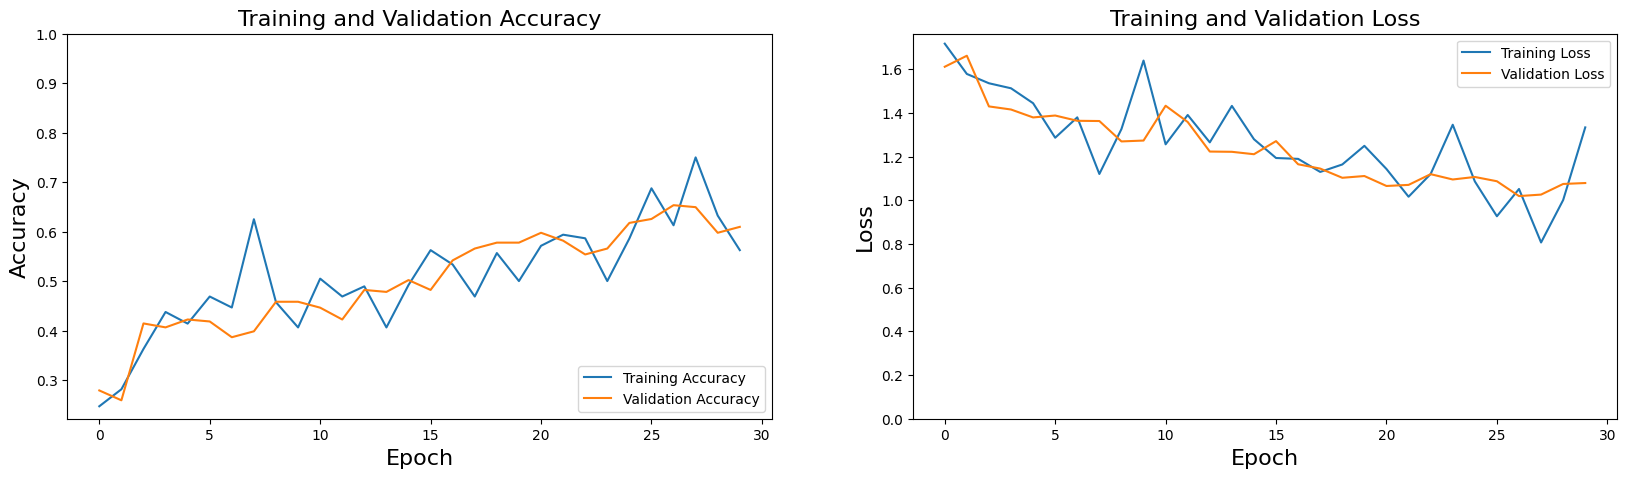

In [17]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'], label ='Training Accuracy')
plt.plot(history.history['val_acc'], label ='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy', fontsize=16)


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label ='Training Loss')
plt.plot(history.history['val_loss'], label ='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss', fontsize=16)
plt.show()

# 6. EVALUACIJA MODELA NA TEST SKUPU

Ovaj korak evaluira performanse istreniranog CNN modela na test skupu podataka koristeći različite metrike (accuracy, loss, precision, recall). Generiše se classification report koji prikazuje detaljne performanse po klasama, kao i
predviđanja modela za dalju analizu i kreiranje confusion matrix-a.


In [18]:
loss, precision, recall, acc = model.evaluate(test_generator, batch_size=32)
print("\nTest Accuracy: %.1f%%" % (100.0 * acc))
print("\nTest Loss: %.1f%%" % (100.0 * loss))
print("\nTest Precision: %.1f%%" % (100.0 * precision))
print("\nTest Recall: %.1f%%" % (100.0 * recall))

# Classification Report
x_test, y_test = next(test_generator)
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - acc: 0.6096 - loss: 1.0786 - precision: 0.7724 - recall: 0.4462

Test Accuracy: 61.0%

Test Loss: 107.9%

Test Precision: 77.2%

Test Recall: 44.6%
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 958ms/step


array([1, 0, 3, 2, 3, 4, 1, 4, 1, 3, 1, 1, 3, 2, 0, 0, 4, 0, 3, 3, 4, 4,
       1, 3, 1, 1, 0, 5, 2, 1, 1, 0, 1, 2, 2, 2, 3, 0, 3, 3, 1, 3, 2, 4,
       1, 1, 2, 2, 3, 2, 5, 1, 4, 0, 1, 0, 3, 1, 0, 0, 4, 2, 2, 2, 3, 3,
       4, 0, 5, 1, 1, 3, 0, 3, 1, 0, 3, 2, 3, 1, 1, 3, 0, 1, 3, 4, 5, 2,
       0, 1, 0, 2, 1, 1, 0, 1, 5, 3, 0, 5, 0, 2, 2, 0, 2, 5, 2, 2, 4, 0,
       4, 1, 2, 3, 2, 1, 3, 3, 1, 3, 3, 3, 3, 4, 4, 3, 5, 3, 3, 3, 0, 1,
       2, 2, 4, 3, 0, 1, 3, 1, 1, 3, 1, 3, 0, 1, 1, 0, 0, 1, 3, 3, 0, 0,
       3, 0, 1, 1, 1, 0, 2, 3, 1, 2, 3, 3, 2, 3, 3, 4, 3, 4, 1, 3, 1, 1,
       3, 2, 3, 3, 2, 0, 0, 1, 4, 2, 2, 4, 0, 3, 3, 1, 1, 0, 1, 1, 0, 0,
       3, 1, 1, 3, 1, 2, 1, 3, 1, 0, 1, 3, 0, 4, 0, 3, 1, 3, 5, 3, 0, 3,
       4, 0, 3, 3, 0, 1, 2, 3, 0, 1, 0, 0, 3, 3, 3, 0, 2, 1, 2, 5, 5, 4,
       1, 4, 1, 3, 4, 4, 3, 0, 2])

Sledi generisanje detaljnog classification report-a koji prikazuje precision, recall i F1-score za svaku klasu otpada pojedinačno.Report omogućava identifikaciju koje klase model najbolje klasifikuje i gde postoje problemi u prepoznavanju, što je korisno za dalju optimizaciju modela.

In [19]:
target_names = list(waste_labels.keys())
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   cardboard       0.60      0.72      0.66        40
       glass       0.61      0.76      0.68        50
       metal       0.54      0.49      0.51        41
       paper       0.69      0.80      0.74        59
     plastic       0.52      0.27      0.36        48
       trash       0.55      0.46      0.50        13

    accuracy                           0.61       251
   macro avg       0.59      0.58      0.57       251
weighted avg       0.60      0.61      0.59       251



Ovaj korak kreira confusion matrix koji vizuelno prikazuje performanse modela
kroz matricu gde se vide tačni i netačni klasifikacije za sve kombinacije
stvarnih i predviđenih klasa. Matrix omogućava identifikaciju koje klase se
najčešće mešaju između sebe i gde model pravi najveće greške, što je ključno
za razumevanje slabosti modela i dalje poboljšanje.

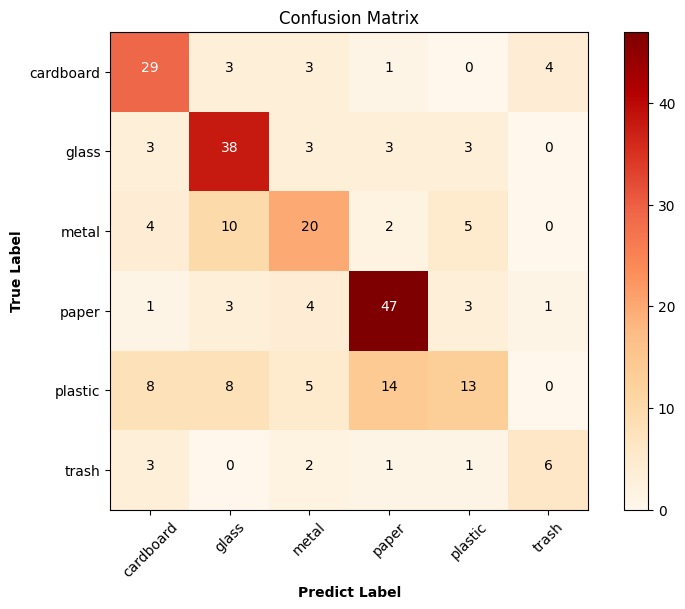

In [21]:
cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label', fontweight="bold")
    plt.xlabel('Predict Label', fontweight="bold")
    plt.show()

plot_confusion_matrix(cm, waste_labels,
                      title='Confusion Matrix',
                      cmap=plt.cm.OrRd)

Funkcija model_testing je funkcija za testiranje istreniranog modela na pojedinačnim slikama iz dataseta. učitava sliku, preprocessira je
(resize, normalizacija) i generiše predviđanje sa verovatnoćama za sve klase. Zatim se testira model na po jednoj slici iz svake kategorije otpada i vizualno prikazuju rezultati sa maksimalnim verovatnoćama i predviđenim klasama.

In [22]:
waste_labels = {0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}

def model_testing(path):
  img = image.load_img(path, target_size=(target_size))
  img = image.img_to_array(img, dtype=np.uint8)
  img=np.array(img)/255.0
  p=model.predict(img.reshape(1, 224, 224, 3))
  predicted_class = np.argmax(p[0])

  return img, p, predicted_class

Testiranje modela na po jednoj slici iz svake kategorije otpada radi evaluacije performansi na realnim primerima. Svaki poziv model_testing funkcije vraća preprocessiranu sliku, verovatnoće za sve klase i predviđenu klasu.

In [23]:
img1, p1, predicted_class1 = model_testing('/content/dataset-resized/metal/metal1.jpg')
img2, p2, predicted_class2 = model_testing('/content/dataset-resized/glass/glass5.jpg')
img3, p3, predicted_class3 = model_testing('/content/dataset-resized/cardboard/cardboard13.jpg')
img4, p4, predicted_class4 = model_testing('/content/dataset-resized/paper/paper106.jpg')
img5, p5, predicted_class5 = model_testing('/content/dataset-resized/plastic/plastic14.jpg')
img6, p6, predicted_class6 = model_testing('/content/dataset-resized/trash/trash26.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Prikazivanje test slike u grid formatu 2x3 sa predviđenim klasama i verovatnoćama. Svaka slika je označena maksimalnom verovatnoćom predviđanja i predviđenom klasom otpada radi vizuelne provere performansi modela na konkretnim primerima.

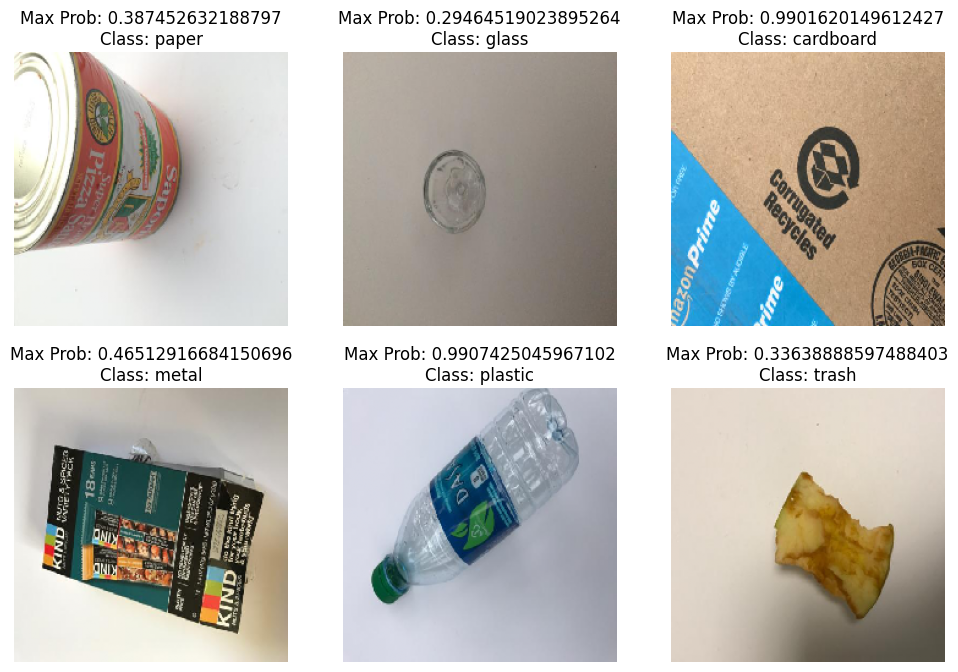

In [24]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.axis('off')
plt.imshow(img1.squeeze())
plt.title(f"Max Prob: {np.max(p1[0])}\nClass: {waste_labels[predicted_class1]}")

plt.subplot(2, 3, 2)
plt.axis('off')
plt.imshow(img2.squeeze())
plt.title(f"Max Prob: {np.max(p2[0])}\nClass: {waste_labels[predicted_class2]}")

plt.subplot(2, 3, 3)
plt.axis('off')
plt.imshow(img3.squeeze())
plt.title(f"Max Prob: {np.max(p3[0])}\nClass: {waste_labels[predicted_class3]}")

plt.subplot(2, 3, 4)
plt.axis('off')
plt.imshow(img4.squeeze())
plt.title(f"Max Prob: {np.max(p4[0])}\nClass: {waste_labels[predicted_class4]}")

plt.subplot(2, 3, 5)
plt.axis('off')
plt.imshow(img5.squeeze())
plt.title(f"Max Prob: {np.max(p5[0])}\nClass: {waste_labels[predicted_class5]}")

plt.subplot(2, 3, 6)
plt.axis('off')
plt.imshow(img6.squeeze())
plt.title(f"Max Prob: {np.max(p6[0])}\nClass: {waste_labels[predicted_class6]}")

plt.show()